# Aircraft Classification Using CNN

First of all, Import all the libraries we’ll need during our model building phase.

In [184]:
import pandas as pd
import numpy as np 
import itertools
import keras
import tensorflow
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D,MaxPooling2D
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import applications
from keras.optimizers import adam
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import IPython.display as display
from PIL import Image
import math, os
import pathlib

As I didn't had the dataset of aircrafts to train the model, so I downloaded data from google manually by using Image Downloader. I had selected 6 aircraft and downloaded approx 100 images of each aircraft. Then I divided my dataset in two folder i.e. "train" and "test". "train" folder contains total 480 images, 80 images each of aircrafts in 6 folders & "test" folder contains 120 images ,20 images each of aircrafts in 6 folder.

In [162]:
img_width, img_height = 224, 224    #defining the dimensions of the image
# loading up our datasets
train_data_dir = 'data/train'    
test_data_dir = 'data/test'
epochs = 10        # number of epochs to train top model
batch_size = 40    # batch size used by flow_from_directory and predict_generator

In [163]:
# To check total number of images in directory or sub-directory
data_dir = pathlib.Path(train_data_dir)
image_count = len(list(data_dir.glob('*/*.*')))
print("Total images:",image_count)

Total images: 480


In [164]:
# To check total numbers of classes
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
print("Classes :", CLASS_NAMES)

Classes : ['boeing 737' 'falcon 900' 'airbus A380' 'challenger 600' 'hawk T1'
 'boeing 707']


As data is downloaded directly from google, so we have colors & greyscale images combined in folders. The dimensions of images are also not fixed, so our data needs pre-processing.

In this block, we are importing the transfer learning aspect of the convolutional neural network. Transfer learning is handy because it comes with pre-made neural networks and other necessary components that we would otherwise have to create.
We will convert and save the file to the bottleneck file.

In [165]:
#Importing transfer learning model VGG16
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1./ 255)

#Creation of the weights and feature using VGG16
generator = datagen.flow_from_directory(train_data_dir,target_size=(img_width, img_height),batch_size=batch_size,
                                        shuffle= False, class_mode=None, interpolation= 'nearest') 
train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)
predict_size_train = int(math.ceil(train_samples / batch_size))
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)
np.save('bottleneck_features_train.npy', bottleneck_features_train) #create & save the bottleneck .npy file for training.

generator = datagen.flow_from_directory(test_data_dir,target_size=(img_width,img_height), batch_size=batch_size,
                                        class_mode=None,shuffle=False, interpolation= 'nearest')
test_samples = len(generator.filenames)
predict_size_test = int(math.ceil(test_samples/batch_size))
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)
np.save('bottleneck_features_test.npy', bottleneck_features_test)  #create & save the bottleneck .npy file for testing.

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


Found 480 images belonging to 6 classes.


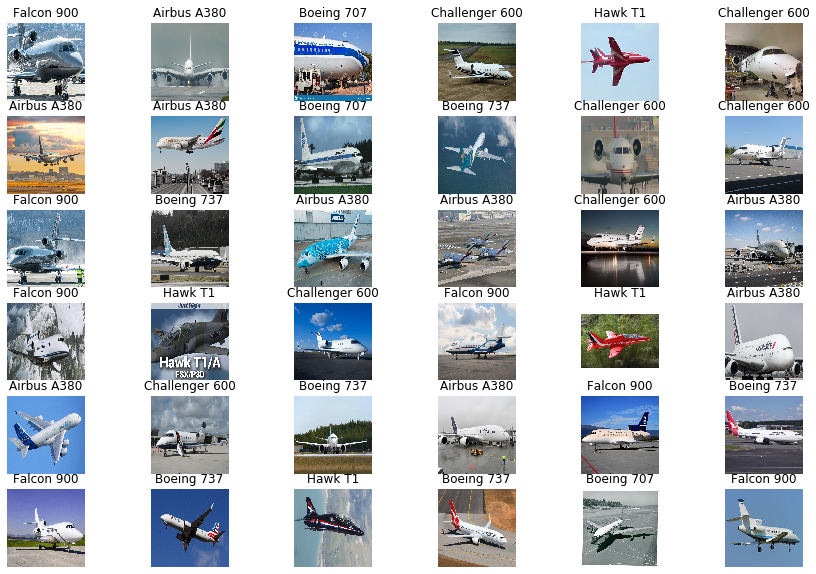

In [166]:
#To show 36 random images from our training dataset
generator = datagen.flow_from_directory(train_data_dir,target_size=(img_width, img_height),batch_size=batch_size,
                                        shuffle= True, classes = list(CLASS_NAMES),interpolation= 'nearest')
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(15,10))
    for n in range(36):
        ax = plt.subplot(6,6,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
image_batch, label_batch = next(generator)
show_batch(image_batch, label_batch)

Once the files have been converted and saved to the bottleneck file, we load them and prepare them for our convolutional neural network.

In [171]:
datagen_top = ImageDataGenerator(rescale=1./255)
generator_top = datagen_top.flow_from_directory(train_data_dir,target_size=(img_width, img_height),
                                                batch_size=batch_size, class_mode='categorical', shuffle=False,
                                                interpolation= 'nearest')
train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)
# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')
# get the class lebels for the training data, in the original order
train_labels = generator_top.classes
# convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes=num_classes)

generator_top = datagen_top.flow_from_directory(test_data_dir,target_size=(img_width, img_height),
                                                batch_size=batch_size, class_mode=None, shuffle=False,
                                                interpolation= 'nearest') 
nb_test_samples = len(generator_top.filenames)
test_data = np.load('bottleneck_features_test.npy')
test_labels = generator_top.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 480 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


We will create a simple architecture, add convolutional layers, and flatten the result to feed into the densely connected layers,Finally we add the densely connected layers.

Note that because we are facing a multi-class classification problem, i.e. a categorical classification problem, we will end our network with a softmax activation.

In [172]:
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  #Flatten the results to feed into a DNN
model.add(Dense(100, activation= tensorflow.keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation= tensorflow.keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  #6 output neuron.

In [173]:
model.summary()    # model.summary() method call prints a summary of the NN

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               2508900   
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 306       
Total params: 2,514,256
Trainable params: 2,514,256
Non-trainable params: 0
___________________________________________

The "output shape" column above shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding.

Next, we will compile the model we’ve created. We will train our model with the categorical_crossentropy loss, because it is a categorical classification problem.

In [174]:
model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer= "adam")

In this step, we will train the model on the training set images and cross validate it using the validation_split.
We will train the model for 10 epochs.

The Loss and Accuracy are a great indication of progress of training.

In [175]:
history = model.fit(train_data, train_labels, epochs=10, batch_size=batch_size, validation_split=0.2)

Train on 384 samples, validate on 96 samples
Epoch 1/10
384/384 [==============================] - 2s 4ms/sample - loss: 4.1062 - accuracy: 0.2266 - val_loss: 6.8219 - val_accuracy: 0.1667
Epoch 2/10
384/384 [==============================] - 0s 1ms/sample - loss: 2.6222 - accuracy: 0.3411 - val_loss: 3.7115 - val_accuracy: 0.0104
Epoch 3/10
384/384 [==============================] - 0s 1ms/sample - loss: 1.7537 - accuracy: 0.4792 - val_loss: 7.8308 - val_accuracy: 0.0833
Epoch 4/10
384/384 [==============================] - 1s 1ms/sample - loss: 1.3816 - accuracy: 0.6094 - val_loss: 4.8037 - val_accuracy: 0.1146
Epoch 5/10
384/384 [==============================] - 1s 1ms/sample - loss: 0.9757 - accuracy: 0.6745 - val_loss: 5.1326 - val_accuracy: 0.0938
Epoch 6/10
384/384 [==============================] - 1s 1ms/sample - loss: 0.7631 - accuracy: 0.7161 - val_loss: 4.3293 - val_accuracy: 0.0521
Epoch 7/10
384/384 [==============================] - 1s 2ms/sample - loss: 0.5221 - accura

In [176]:
model.save_weights('model_saved.h5')   #will save the weights,so that we don't have to train model again & again

In [177]:
(eval_loss, eval_accuracy) = model.evaluate( train_data, train_labels, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

480/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[INFO] accuracy: 81.04%
[INFO] Loss: 1.3219611678893368


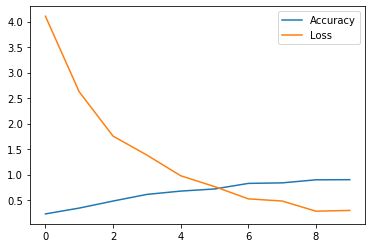

In [178]:
# Accruacy and Loss
val_acc = history.history['accuracy']
val_loss = history.history['loss']
plt.plot(val_acc)
plt.plot(val_loss)
plt.legend(['Accuracy', 'Loss'])

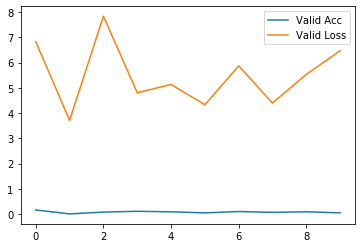

In [179]:
# Validation Accruacy and Validation Loss
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
plt.plot(val_acc)
plt.plot(val_loss)
plt.legend(['Valid Acc', 'Valid Loss'])

In [180]:
model.evaluate(test_data, test_labels)

120/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.2967976252237956, 0.49166667]

In [181]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
print('rounded test_labels', preds)

test data [[[[1.63655747e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.17698872e-01 0.00000000e+00]
   [2.01963149e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.14716434e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.41999328e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.56946242e-01 0.00000000e+00]
   [6.44324124e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.64502305e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    3.95306498e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.63196886e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.56515419e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.29718304e-01 0.00000000e+00]
   ...
   [2.94719130e-01 0.00000000e+00 0.00000000e+0

rounded test_labels [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 

In [182]:
aircrafts = ['boeing 737', 'falcon 900', 'airbus A380', 'challenger 600', 'hawk T1', 'boeing 707']
classification_metrics = metrics.classification_report(test_labels, preds, target_names= aircrafts )
print(classification_metrics)

                precision    recall  f1-score   support

    boeing 737       0.52      0.55      0.54        20
    falcon 900       0.45      0.50      0.48        20
   airbus A380       0.42      0.50      0.45        20
challenger 600       0.57      0.85      0.68        20
       hawk T1       0.71      0.25      0.37        20
    boeing 707       0.00      0.00      0.00        20

     micro avg       0.51      0.44      0.47       120
     macro avg       0.45      0.44      0.42       120
  weighted avg       0.45      0.44      0.42       120
   samples avg       0.44      0.44      0.44       120



/home/bipinpanwar55/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/bipinpanwar55/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
